In [2]:
import sqlite3
import pandas as pd

# Connect to the SQLite database (if the database doesn't exist, it will be created)
conn = sqlite3.connect('Main_DB')

# Create a cursor object to interact with the database
cursor = conn.cursor()

# Your SQL query
temp_df = '''
SELECT * from wind
'''

# Read SQL query result into a DataFrame
wind = pd.read_sql_query(temp_df, conn)
wind.rename(columns={'value': 'wind_generation'}, inplace=True)

# Your SQL query
temp_df = '''
SELECT * from spot_price
'''

# Read SQL query result into a DataFrame
spot_price = pd.read_sql_query(temp_df, conn)

# Read SQL query result into a DataFrame
spot_price = pd.read_sql_query(temp_df, conn)
spot_price.rename(columns={'value': 'spot_price'}, inplace=True)

# Your SQL query
temp_df = '''
SELECT * from solar
'''

# Read SQL query result into a DataFrame
solar = pd.read_sql_query(temp_df, conn)
solar.rename(columns={'value': 'solar_generation'}, inplace=True)

# Your SQL query
temp_df = '''
SELECT * from demand
'''

# Read SQL query result into a DataFrame
demand = pd.read_sql_query(temp_df, conn)
demand.rename(columns={'value': 'demand'}, inplace=True)

# SQL query
temp_df = '''
SELECT * from gas_data
'''

# Read SQL query result into a DataFrame
gas_data = pd.read_sql_query(temp_df, conn)
gas_data.rename(columns={'value': 'gas_price'}, inplace=True)
gas_data_hourly = gas_data.reindex(gas_data.index.repeat(24)).reset_index(drop=True)

# Close the connection
conn.close()

# Display the DataFrame


In [3]:
df=wind.merge(spot_price, left_on=['day', 'hour'], right_on=['day', 'hour']) \
        .merge(solar, left_on=['day', 'hour'], right_on=['day', 'hour']) \
        .merge(demand, left_on=['day', 'hour'], right_on=['day', 'hour']) \
        .merge(gas_data, left_on=['day'], right_on=['delivery_day'])\
        .drop('delivery_day', axis=1)

df

,wind_generation,day,hour,spot_price,solar_generation,demand,index_price
0,3214.0,2019-01-01,01:00,66.88,0.0,23753.0,24.45
1,3214.0,2019-01-01,01:00,66.88,0.0,23753.0,24.45
2,3222.0,2019-01-01,02:00,66.88,0.0,23018.0,24.45
3,3222.0,2019-01-01,02:00,66.88,0.0,23018.0,24.45
4,3081.0,2019-01-01,03:00,66.00,0.0,21808.0,24.45
...,...,...,...,...,...,...,...
70278,1942.0,2023-12-24,21:00,109.30,0.0,27489.3,31.61
70279,1836.0,2023-12-24,22:00,92.85,0.0,25901.0,31.61
70280,1731.0,2023-12-24,23:00,76.93,0.0,23392.3,31.61
70281,1700.5,2023-12-25,00:00,72.23,0.0,21857.0,NaN


In [4]:
df = df.dropna()


In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

X = df[['wind_generation', 'solar_generation', 'demand', 'index_price']]
y = df['spot_price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [6]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)

In [7]:
coefficients = reg.coef_
intercept = reg.intercept_

print('Intercept:', intercept)
print('Coefficients:', coefficients)

Intercept: -13.198442323759181
Coefficients: [-0.00285877 -0.0030128   0.00223912  1.59386166]


In [8]:
reg.score(X, y)

0.7394052538870195

In [9]:
pred_reg = reg.predict(X_test)

In [10]:
from sklearn.metrics import mean_squared_error, r2_score

# Assuming pred_reg contains the predicted values from the regression model
# y_test contains the actual target values

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, pred_reg)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate R-squared
r2 = r2_score(y_test, pred_reg)
print(f"R-squared (R2): {r2}")


Mean Squared Error (MSE): 1118.4617321266603
R-squared (R2): 0.7354090676143145


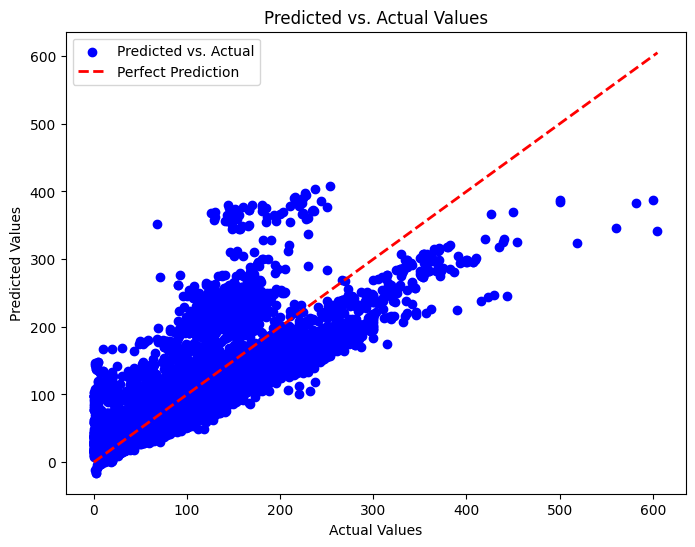

In [11]:
import matplotlib.pyplot as plt

# Assuming pred_reg contains the predicted values from the regression model
# y_test contains the actual target values

# Plotting the predicted values vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, pred_reg, color='blue', label='Predicted vs. Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.legend()
plt.show()


In [12]:
import pandas as pd

# Assuming pred_reg contains the predicted values and y_test contains the actual values
# Creating a DataFrame with 'Predicted' and 'Actual' columns
df_comparison = pd.DataFrame({
    'Predicted': pred_reg,  # Replace 'pred_reg' with your predicted values
    'Actual': y_test        # Replace 'y_test' with your actual values
})

# Display the DataFrame
print(df_comparison)


        Predicted  Actual
16072   40.687509   41.59
39096   44.394371   55.27
16368   74.201390   52.75
19688   55.219905   41.35
15938   54.982033   44.98
...           ...     ...
55197  145.752768  145.10
29643   37.638394   45.86
62184  114.401238   71.72
4040    29.377201   30.22
56968  223.205834  149.84

[17571 rows x 2 columns]


In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

regressor = DecisionTreeRegressor(random_state=42, min_samples_split=50)
regressor.fit(X_train, y_train)

# Predict on the test set
pred_CART = regressor.predict(X_test)

# Calculate Mean Squared Error (MSE) to evaluate the model
mse = mean_squared_error(y_test, pred_CART)
print("Mean Squared Error:", mse)

Mean Squared Error: 416.7686929822995


In [19]:
df_comparison = pd.DataFrame({
    'Predicted': pred_CART,  # Replace 'pred_reg' with your predicted values
    'Actual': y_test        # Replace 'y_test' with your actual values
})

# Display the DataFrame
X_test

,wind_generation,solar_generation,demand,index_price
16072,8628.0,1122.1,26583.0,14.06
39096,12222.0,0.0,29253.0,16.96
16368,1390.0,0.0,30885.0,13.94
19688,6981.0,916.5,33655.0,9.90
15938,11337.0,0.0,34261.0,14.98
...,...,...,...,...
55197,13313.0,8129.0,31122.0,95.25
29643,10105.0,1681.8,30202.0,10.77
62184,12665.3,202.1,28882.8,62.58
4040,11895.0,0.0,22805.0,16.01


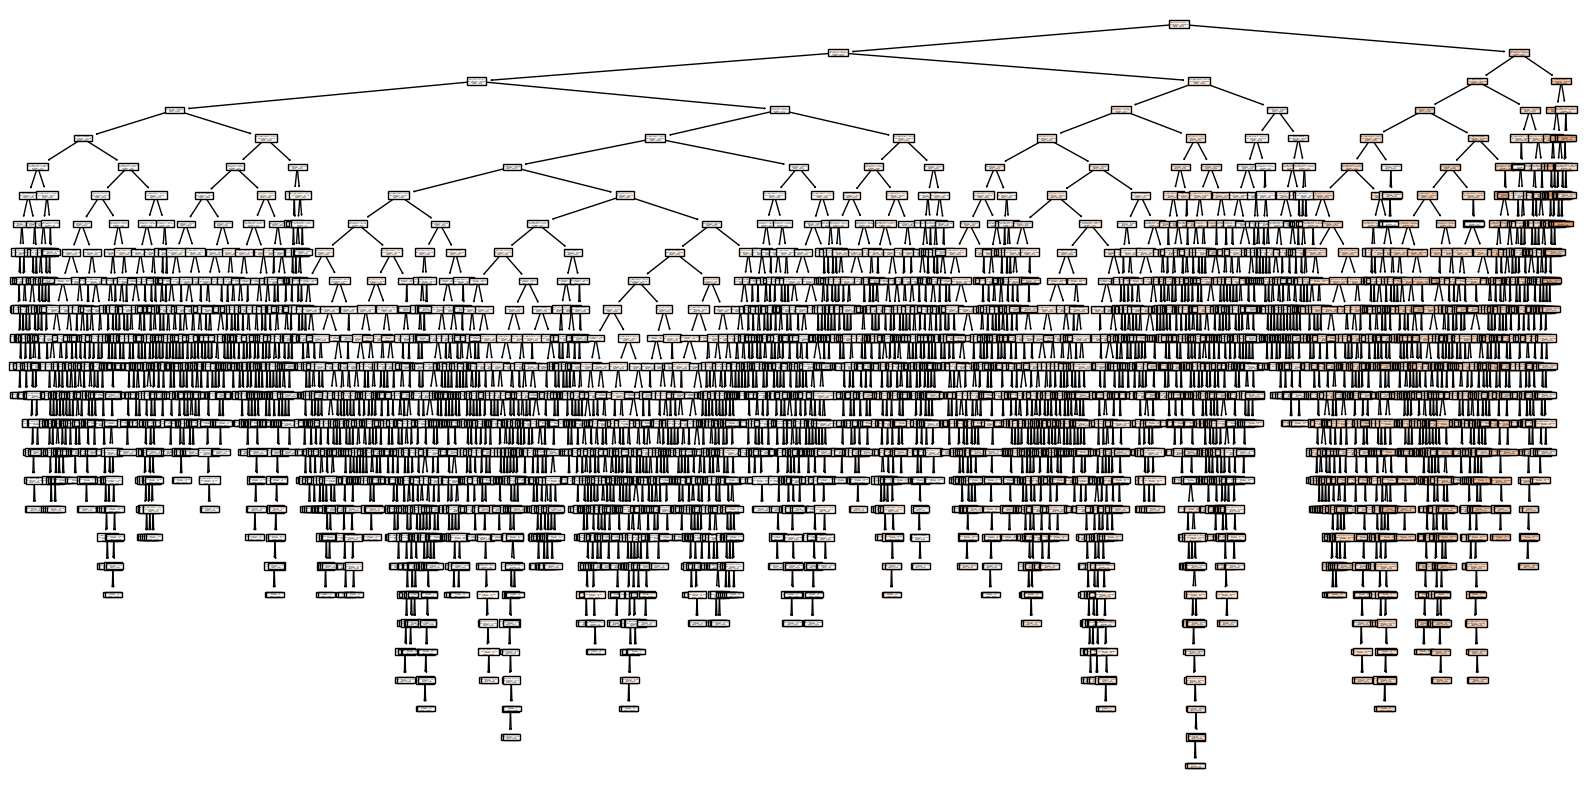

In [15]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

feature_names = list(df.columns)  # Convert DataFrame columns to a list of strings

plt.figure(figsize=(20, 10))  # Set the figure size as needed
plot_tree(regressor, filled=True, feature_names=feature_names)
plt.show()


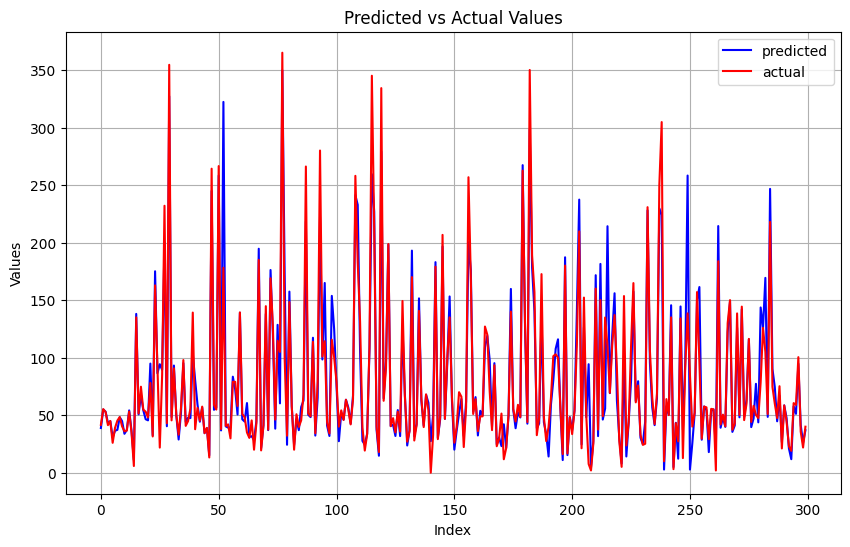

In [27]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing the 'Predicted' and 'Actual' columns
# Replace 'df' with your actual DataFrame name

# Extracting 'Predicted' and 'Actual' columns from the DataFrame for the first 100 hours
predicted_values = df_comparison['Predicted'].iloc[:300]  # Selecting first 100 values
actual_values = df_comparison['Actual'].iloc[:300]  # Selecting first 100 values

# Creating a scatter plot for the first 100 hours
plt.figure(figsize=(10, 6))


# Connecting the dots with lines
plt.plot(range(len(predicted_values)), predicted_values, label='predicted', color='blue')  # Line connecting 'Predicted' values
plt.plot(range(len(actual_values)), actual_values, label='actual', color='red')  # Line connecting 'Actual' values

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()
